# 4. 잠재 요인 협업 필터링

## 경사하강을 이용한 행렬 분해

R, P, Q 정의

In [1]:
import numpy as np

# 원본 행렬 R 생성, 분해 행렬 P와 Q 초기화, 잠재요인 차원 K는 3 설정. 
R = np.array([[4, np.NaN, np.NaN, 2, np.NaN ],
              [np.NaN, 5, np.NaN, 3, 1 ],
              [np.NaN, np.NaN, 3, 4, 4 ],
              [5, 2, 1, 2, np.NaN ]])
num_users, num_items = R.shape
K=3

# P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 random한 값으로 입력합니다. 
np.random.seed(1)
P = np.random.normal(scale=1./K, size=(num_users, K))
Q = np.random.normal(scale=1./K, size=(num_items, K))

예측 행렬의 오차를 구하는 `get_rmse` 정의

In [2]:
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
      
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse



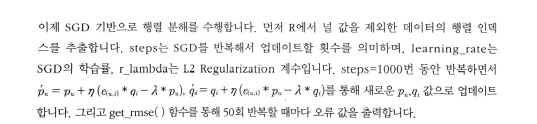

행렬 분해

In [3]:
# R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트에 저장. 
non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

steps=1000
learning_rate=0.01
r_lambda=0.01

# SGD 기법으로 P와 Q 매트릭스를 계속 업데이트. 
for step in range(steps):
    for i, j, r in non_zeros:
        # 실제 값과 예측 값의 차이인 오류 값 구함
        eij = r - np.dot(P[i, :], Q[j, :].T)
        # Regularization을 반영한 SGD 업데이트 공식 적용
        P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
        Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

    rmse = get_rmse(R, P, Q, non_zeros)
    if (step % 50) == 0 :
        print("### iteration step : ", step," rmse : ", rmse)




### iteration step :  0  rmse :  3.2388050277987723
### iteration step :  50  rmse :  0.4876723101369648
### iteration step :  100  rmse :  0.1564340384819247
### iteration step :  150  rmse :  0.07455141311978046
### iteration step :  200  rmse :  0.04325226798579314
### iteration step :  250  rmse :  0.029248328780878973
### iteration step :  300  rmse :  0.022621116143829466
### iteration step :  350  rmse :  0.019493636196525135
### iteration step :  400  rmse :  0.018022719092132704
### iteration step :  450  rmse :  0.01731968595344266
### iteration step :  500  rmse :  0.016973657887570753
### iteration step :  550  rmse :  0.016796804595895633
### iteration step :  600  rmse :  0.01670132290188466
### iteration step :  650  rmse :  0.01664473691247669
### iteration step :  700  rmse :  0.016605910068210026
### iteration step :  750  rmse :  0.016574200475705
### iteration step :  800  rmse :  0.01654431582921597
### iteration step :  850  rmse :  0.01651375177473524
### iterati

In [4]:
pred_matrix = np.dot(P, Q.T)
print('예측 행렬:\n', np.round(pred_matrix, 3))

예측 행렬:
 [[3.991 0.897 1.306 2.002 1.663]
 [6.696 4.978 0.979 2.981 1.003]
 [6.677 0.391 2.987 3.977 3.986]
 [4.968 2.005 1.006 2.017 1.14 ]]


# 5. 컨텐츠 기반 필터링 실습

# 장르 속성을 이용한 영화 콘텐츠 기반 필터링

- 사용자가 선호 했던 콘텐츠와 비슷하거나 같은 속성의 콘텐츠를 추천하는것
    - 같은 감독, 같은 장르

## 데이터 로딩 및 가공

shape  
로드

In [30]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies =pd.read_csv('C:/Users/rlaal/OneDrive - UOU/2023-2 학기/파이썬 머신러닝 완벽 가이드/File/Source_file/tmdb-5000-movie-dataset/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, ...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporatio...","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United ...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.2,11800


사용할만한 'id','title', 'genres', 'vote_average', 'vote_count',
                 'popularity', 'keywords', 'overview' 만 추출

In [31]:
movies_df = movies[['id','title', 'genres', 'vote_average', 'vote_count',
                 'popularity', 'keywords', 'overview']]


파라미터 설정  
genres 칼럼 확인

In [32]:
pd.set_option('max_colwidth', 100)
movies_df[['genres','keywords']][:1]


,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


문자열을 객체로 뵨환

In [33]:
from ast import literal_eval

movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

lambda 함수를 이용해 장르명 만 추출(장르명만 필요하니까)

In [34]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [ y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


## 장르 콘텐츠 유사도 측정

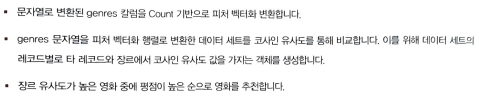

CountVectorizer을 이용해 피처 벡터화

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환. 
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df=1, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


코사인 유사도 측정

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:2])


(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]
 [0.59628479 1.         0.4        ... 0.         0.         0.        ]]


genre_sim.argsort() 사용해 유사도 높은순으로 정렬

In [37]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


## 장르 콘텐츠 필터링을 이용한 영화 추천

영화를 추천하는 함수 생성

In [38]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    
    # 인자로 입력된 movies_df DataFrame에서 'title' 컬럼이 입력된 title_name 값인 DataFrame추출
    title_movie = df[df['title'] == title_name]
    
    # title_named을 가진 DataFrame의 index 객체를 ndarray로 반환하고 
    # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n 개의 index 추출
    title_index = title_movie.index.values
    similar_indexes = sorted_ind[title_index, :(top_n)]
    
    # 추출된 top_n index들 출력. top_n index는 2차원 데이터 임. 
    #dataframe에서 index로 사용하기 위해서 1차원 array로 변경
    print(similar_indexes)
    similar_indexes = similar_indexes.reshape(-1)
    
    return df.iloc[similar_indexes]


영화 'The Godfather' 와 유사한 영화 10 편 추천

In [39]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


몇몇은 제대로 추천 되었으나 'Mi America	' 같 은 영화는 유사도가 0 인데 추천됨   
--> 개선 필요

movies_df 데이터의 평점 순으로 10개 데이터 배열

In [40]:
movies_df[['title','vote_average','vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


몇몇은 평가 횟수가 너무 적음 -->
개선필요

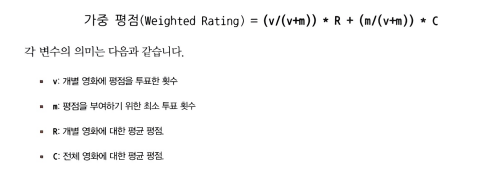

새로운 평가 방식 사용

In [41]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:',round(C,3), 'm:',round(m,3))

C: 6.092 m: 370.2


새로운 평가 함수 weighted_vote_average 생성

In [42]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
    v = record['vote_count']
    R = record['vote_average']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )   

movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis=1) 


'weighted_vote' 값이 높은 순으로 10개 정렬

In [43]:
movies_df[['title','vote_average','weighted_vote','vote_count']].sort_values('weighted_vote',
                                                                          ascending=False)[:10]


,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


다시 한 번 추천  
--> 평점 개선

In [44]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
    title_movie = df[df['title'] == title_name]
    title_index = title_movie.index.values
    
    # top_n의 2배에 해당하는 쟝르 유사성이 높은 index 추출 
    similar_indexes = sorted_ind[title_index, :(top_n*2)]
    similar_indexes = similar_indexes.reshape(-1)
# 기준 영화 index는 제외
    similar_indexes = similar_indexes[similar_indexes != title_index]
    
    # top_n의 2배에 해당하는 후보군에서 weighted_vote 높은 순으로 top_n 만큼 추출 
    return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather',10)
similar_movies[['title', 'vote_average', 'weighted_vote']]


,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


# 6. 아이템 기반 최근접 이웃 협업 필터링 실습

## 데이터 가공 및 변환

In [2]:
import pandas as pd
import numpy as np

movies = pd.read_csv('C:/Users/rlaal/OneDrive - UOU/2023-2 학기/파이썬 머신러닝 완벽 가이드/File/Source_file/ml-latest-small/ml-latest-small/movies.csv')
ratings = pd.read_csv('C:/Users/rlaal/OneDrive - UOU/2023-2 학기/파이썬 머신러닝 완벽 가이드/File/Source_file/ml-latest-small/ml-latest-small/ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


영화에 대한 메타 정보 있음

In [3]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


영화에 대한 평점을 매긴 데이터

In [4]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


아이템 기반의 최근접 추천 시스템을 만들어 보자

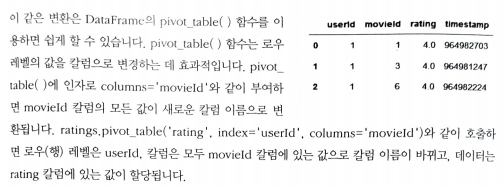

In [48]:
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


대부분 NaN 으로 할당 --> 대부분을 사용자가 평가를 하지 않았기 때문

rating 데이터와 movie 데이터 join  
columns 을 movie 타이틀로 변경  
Nan값 0으로 fillna

In [49]:
# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행. 
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값을 모두 0 으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 영화와 영화들 간 유사도 산출

cosine_similatity 적용하기 위해서는,   
 행이 영화 열이 사용자 가 되어야 하기에 전치 행렬 적용

In [50]:

ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


cosine_similarity 적용

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity() 로 반환된 넘파이 행렬을 영화명을 매핑하여 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                          columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)


(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


5장에서 추천한 장르기반 데이터(대부)와 유사도 비슷한 영화 6개 추출

In [52]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

인셉션과 비슷한 영화 6개 추천

In [53]:
item_sim_df["Inception (2010)"].sort_values(ascending=False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

## 아이템 기반 인접 이웃 협업 필터링으로 개인화된 영화 추천

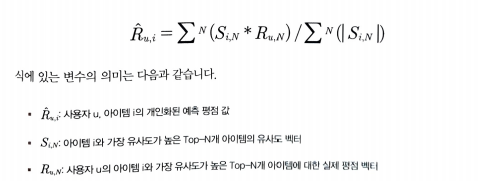

코드 구현

In [54]:
def predict_rating(ratings_arr, item_sim_arr ):
    ratings_pred = ratings_arr.dot(item_sim_arr)/ np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred


개인화된 평점 구함

In [55]:
ratings_pred = predict_rating(ratings_matrix.values , item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


평가 성능 평가를 위해 MSE 구함

In [56]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE 를 구함. 
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

print('아이템 기반 모든 인접 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values ))


아이템 기반 모든 인접 이웃 MSE:  9.895354759094706


유사도가 높은 영화에서만 벡터를 이용해 평가하는 함수 생성?

In [57]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)

    # 사용자-아이템 평점 행렬의 열 크기만큼 Loop 수행. 
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 index 반환
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T) 
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))        
    return pred


In [58]:
ratings_pred = predict_rating_topsim(ratings_matrix.values , item_sim_df.values, n=20)
print('아이템 기반 인접 TOP-20 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values ))


# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)


아이템 기반 인접 TOP-20 이웃 MSE:  3.695009387428144


In [59]:
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[ user_rating_id > 0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Producers, The (1968)                                                             5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Back to the Future (1985)                                                         5.0
Austin Powers in Goldmember (2002)                                                5.0
Minority Report (2002)                                                            4.0
Witness (1985)                                                                    4.0
Name: 9, dtype: float64

In [60]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함. 
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임. 
    user_rating = ratings_matrix.loc[userId,:]
    
    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()
    
    # 모든 영화명을 list 객체로 만듬. 
    movies_list = ratings_matrix.columns.tolist()
    
    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함. 
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]
    
    return unseen_list


In [61]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함. 
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies
    
# 사용자가 관람하지 않는 영화명 추출   
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천 
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성. 
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies


,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


# 7. 행렬 분해를 이용한 잠재 요인 협업 필터링 실습

In [62]:
import numpy as np
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
      
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse


In [63]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다. 
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))
       
    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장. 
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]
   
    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트. 
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])
       
        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)
            
    return P, Q

데이터 로딩

In [65]:
import pandas as pd
import numpy as np

movies = pd.read_csv('C:/Users/rlaal/OneDrive - UOU/2023-2 학기/파이썬 머신러닝 완벽 가이드/File/Source_file/ml-latest-small/ml-latest-small/movies.csv')
ratings = pd.read_csv('C:/Users/rlaal/OneDrive - UOU/2023-2 학기/파이썬 머신러닝 완벽 가이드/File/Source_file/ml-latest-small/ml-latest-small/ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')

# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행. 
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

행렬 분해

In [66]:
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.20685455302331537
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720403
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.17165226964707486
### iteration step :  120  rmse :  0.1669518194687172
### iteration step :  130  rmse :  0.16305292191997542
### iteration step :  140  rmse :  0.15976691929679643
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.15453398186715428
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  r

In [67]:
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)

ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941


In [68]:
def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함. 
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임. 
    user_rating = ratings_matrix.loc[userId,:]
    
    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()
    
    # 모든 영화명을 list 객체로 만듬. 
    movies_list = ratings_matrix.columns.tolist()
    
    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함. 
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]
    
    return unseen_list

In [69]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함. 
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [70]:
# 사용자가 관람하지 않는 영화명 추출   
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천 
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성. 
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


# 8. 파이썬 추천 시스템 패키지

## Suprise 를 이용한 추천 시스템 구축

In [1]:
pip install scikit-surprise

     ---------------------------------------- 0.0/772.0 kB ? eta -:--:--
      --------------------------------------- 10.2/772.0 kB ? eta -:--:--
     - ----------------------------------- 30.7/772.0 kB 435.7 kB/s eta 0:00:02
     ----------- -------------------------- 225.3/772.0 kB 2.3 MB/s eta 0:00:01
     -------------------------------------  768.0/772.0 kB 5.4 MB/s eta 0:00:01
     -------------------------------------- 772.0/772.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp311-cp311-win_amd64.whl size=1079264 sha256=5f01a42ba03c6c630f4e24d5a7c9b06d85eba4ab5f898c1d41b02f80ae8b4b23
  Stored in directory: c:\users\rlaal\appdata\local\pip\cache\wheels\f4\2b\26\e2a5eae55d3b7688995e66abe7f40473aac6c95ddd8ee174a8
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [2]:
import surprise 

print(surprise.__version__)

1.1.3


In [3]:
from surprise import SVD
from surprise import Dataset 
from surprise import accuracy 
from surprise.model_selection import train_test_split

In [5]:
data = Dataset.load_builtin('ml-100k')
# 수행 시마다 동일하게 데이터를 분할하기 위해 random_state 값 부여
trainset, testset = train_test_split(data, test_size=.25, random_state=0) 

In [6]:
algo = SVD(random_state=0)
algo.fit(trainset) 

In [7]:
predictions = algo.test( testset )
print('prediction type :',type(predictions), ' size:',len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

prediction type : <class 'list'>  size: 25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.5114147666251547, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.573872419581491, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.033583485472447, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.8463639495936905, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.1807542478219157, details={'was_impossible': False})]

In [8]:
[ (pred.uid, pred.iid, pred.est) for pred in predictions[:3] ]

[('120', '282', 3.5114147666251547),
 ('882', '291', 3.573872419581491),
 ('535', '507', 4.033583485472447)]

In [9]:
# 사용자 아이디, 아이템 아이디는 문자열로 입력해야 함. 
uid = str(196)
iid = str(302)
pred = algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.49   {'was_impossible': False}


In [10]:
accuracy.rmse(predictions)

RMSE: 0.9467


0.9466860806937948

## Suprise 주요 모듈 소개

In [12]:
import pandas as pd

ratings = pd.read_csv('C:/Users/rlaal/OneDrive - UOU/2023-2 학기/파이썬 머신러닝 완벽 가이드/File/Source_file/ml-latest-small/ml-latest-small/ratings.csv')
# ratings_noh.csv 파일로 unload 시 index 와 header를 모두 제거한 새로운 파일 생성.  
ratings.to_csv('C:/Users/rlaal/OneDrive - UOU/2023-2 학기/파이썬 머신러닝 완벽 가이드/File/Source_file/ml-latest-small/ml-latest-small/noh.csv', index=False, header=False)


In [13]:
from surprise import Reader

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
data=Dataset.load_from_file('C:/Users/rlaal/OneDrive - UOU/2023-2 학기/파이썬 머신러닝 완벽 가이드/File/Source_file/ml-latest-small/ml-latest-small/noh.csv',reader=reader)

In [14]:
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

# 수행시마다 동일한 결과 도출을 위해 random_state 설정 
algo = SVD(n_factors=50, random_state=0)

# 학습 데이터 세트로 학습 후 테스트 데이터 세트로 평점 예측 후 RMSE 평가
algo.fit(trainset) 
predictions = algo.test( testset )
accuracy.rmse(predictions)


RMSE: 0.8682


0.8681952927143516

In [17]:
import pandas as pd
from surprise import Reader, Dataset

ratings = pd.read_csv('C:/Users/rlaal/OneDrive - UOU/2023-2 학기/파이썬 머신러닝 완벽 가이드/File/Source_file/ml-latest-small/ml-latest-small/ratings.csv') 
reader = Reader(rating_scale=(0.5, 5.0))

# ratings DataFrame 에서 컬럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 합니다. 
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

algo = SVD(n_factors=50, random_state=0)
algo.fit(trainset) 
predictions = algo.test( testset )
accuracy.rmse(predictions)


RMSE: 0.8682


0.8681952927143516

## 교차 검증과 하이퍼 파라미터 튜닝

In [18]:
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings = pd.read_csv('C:/Users/rlaal/OneDrive - UOU/2023-2 학기/파이썬 머신러닝 완벽 가이드/File/Source_file/ml-latest-small/ml-latest-small/ratings.csv') # reading data in pandas df
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo = SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8770  0.8809  0.8683  0.8677  0.8730  0.8734  0.0051  
MAE (testset)     0.6733  0.6766  0.6694  0.6679  0.6690  0.6712  0.0032  
Fit time          0.83    0.91    0.83    0.78    0.85    0.84    0.04    
Test time         0.09    0.10    0.10    0.19    0.09    0.11    0.04    


{'test_rmse': array([0.87697776, 0.88090946, 0.8682918 , 0.86770871, 0.8729851 ]),
 'test_mae': array([0.67325061, 0.67662676, 0.66935701, 0.66793472, 0.66895355]),
 'fit_time': (0.825814962387085,
  0.9085686206817627,
  0.8277847766876221,
  0.7784910202026367,
  0.8457372188568115),
 'test_time': (0.09175539016723633,
  0.10172748565673828,
  0.0967409610748291,
  0.18650078773498535,
  0.09400582313537598)}

In [19]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정.
param_grid = {'n_epochs': [20, 40, 60], 'n_factors': [50, 100, 200] }

# CV를 3개 폴드 세트로 지정, 성능 평가는 rmse, mse로 수행하도록 GridSearchCV 구성
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8783101713736111
{'n_epochs': 20, 'n_factors': 50}


## Suprise 를 이용한 개인화 영화 추천 시스템 구축

In [21]:
# 다음 코드는 train_test_split( )으로 분리되지 않는 데이터 세트에 fit( )을 호출해 오류가 발생합니다.
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
algo = SVD(n_factors=50, random_state=0)
algo.fit(data)


AttributeError: 'DatasetAutoFolds' object has no attribute 'n_users'

In [22]:
from surprise.dataset import DatasetAutoFolds

reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DatasetAutoFolds 클래스를 ratings_noh.csv 파일 기반으로 생성. 
data_folds = DatasetAutoFolds(ratings_file='C:/Users/rlaal/OneDrive - UOU/2023-2 학기/파이썬 머신러닝 완벽 가이드/File/Source_file/ml-latest-small/ml-latest-small/noh.csv', reader=reader)

#전체 데이터를 학습데이터로 생성함. 
trainset = data_folds.build_full_trainset()


In [23]:
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)


In [25]:
# 영화에 대한 상세 속성 정보 DataFrame로딩
movies = pd.read_csv('C:/Users/rlaal/OneDrive - UOU/2023-2 학기/파이썬 머신러닝 완벽 가이드/File/Source_file/ml-latest-small/ml-latest-small/movies.csv')

# userId=9 의 movieId 데이터 추출하여 movieId=42 데이터가 있는지 확인. 
movieIds = ratings[ratings['userId']==9]['movieId']
if movieIds[movieIds==42].count() == 0:
    print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])


사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [26]:
uid = str(9)
iid = str(42)

pred = algo.predict(uid, iid, verbose=True)


user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


In [27]:
def get_unseen_surprise(ratings, movies, userId):
    #입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
    seen_movies = ratings[ratings['userId']== userId]['movieId'].tolist()
    
    # 모든 영화들의 movieId를 리스트로 생성. 
    total_movies = movies['movieId'].tolist()
    
    # 모든 영화들의 movieId중 이미 평점을 매긴 영화의 movieId를 제외하여 리스트로 생성
    unseen_movies= [movie for movie in total_movies if movie not in seen_movies]
    print('평점 매긴 영화수:',len(seen_movies), '추천대상 영화수:',len(unseen_movies), \
          '전체 영화수:',len(total_movies))
    
    return unseen_movies

unseen_movies = get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화수: 46 추천대상 영화수: 9696 전체 영화수: 9742


In [28]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
    # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
    predictions = [algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]
    
    # predictions list 객체는 surprise의 Predictions 객체를 원소로 가지고 있음.
    # [Prediction(uid='9', iid='1', est=3.69), Prediction(uid='9', iid='2', est=2.98),,,,]
    # 이를 est 값으로 정렬하기 위해서 아래의 sortkey_est 함수를 정의함.
    # sortkey_est 함수는 list 객체의 sort() 함수의 키 값으로 사용되어 정렬 수행.
    def sortkey_est(pred):
        return pred.est
    
    # sortkey_est( ) 반환값의 내림 차순으로 정렬 수행하고 top_n개의 최상위 값 추출.
    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions= predictions[:top_n]
    
    # top_n으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
    top_movie_ids = [ int(pred.iid) for pred in top_predictions]
    top_movie_rating = [ pred.est for pred in top_predictions]
    top_movie_titles = movies[movies.movieId.isin(top_movie_ids)]['title']
    top_movie_preds = [ (id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]
    
    return top_movie_preds

unseen_movies = get_unseen_surprise(ratings, movies, 9)
top_movie_preds = recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)
print('##### Top-10 추천 영화 리스트 #####')

for top_movie in top_movie_preds:
    print(top_movie[1], ":", top_movie[2])

평점 매긴 영화수: 46 추천대상 영화수: 9696 전체 영화수: 9742
##### Top-10 추천 영화 리스트 #####
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122658
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957
